In this notebook, we evaluate accuracy and precision of `Skylens` angular power spectra.
- Theory: We compare the code against `CCL`, which does similar calculations.
- Pseudo-$C_{\ell}$: We generate a simulation with a complicated mask; we then measure the observed angular power spectra with `healpy` and compare against `Skylens`

In [1]:
#auto load changes 
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

In [2]:
import sys
import pyccl as ccl
import pickle

import camb
from camb import model, initialpower
from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import default_cosmology
from astropy import units
import astropy

import numpy as np
import pandas as pd

sys.path.insert(0,'/global/homes/t/tanveerk/SkyLens/') #path to skylens
sys.path.insert(0,'/global/homes/t/tanveerk/SkyLens/skylens') #path to skylens
sys.path.insert(0,'/global/homes/t/tanveerk/lselgsXplanck/src/') #path to helper functions

import skylens
import utilsCross #helper functions

import matplotlib.pyplot as plt
plt.style.use("seaborn-paper")

skylens main: /global/homes/t/tanveerk/SkyLens/skylens/__init__.py


## Define cosmology

In [3]:
from astropy.cosmology import Planck18_arXiv_v2 as cosmo_planck

cosmo_fid=dict({'h':cosmo_planck.h,
                'Omb':cosmo_planck.Ob0,
                'Omd':cosmo_planck.Om0-cosmo_planck.Ob0,
                's8':0.817,
                'Om':cosmo_planck.Om0,
                'Ase9':2.2,
                'mnu':0,
                'Omk':cosmo_planck.Ok0,
                'tau':0.06,
                'ns':0.965,
                'OmR':cosmo_planck.Ogamma0+cosmo_planck.Onu0,
                'w':-1,
                'wa':0,
                'T_cmb':cosmo_planck.Tcmb0, 
                'Neff':cosmo_planck.Neff,
                'z_max':1090,
                'use_astropy':True})

In [4]:
pk_params={'non_linear':1,
           'kmax':10,
           'kmin':3.e-4,
           'nk':500,
           'scenario':'dmo', 
           'halofit_version':'takahashi',
           'pk_func' :'camb_pk'}

In [5]:
cosmo_params = cosmo_fid

# Test of Theory $C_{\ell}$

## Setup `Skylens`

In this section, we calculate both theory angular power spectra and the window convolved pseudo-$C_{\ell}$s.

Setting up virtual dask cluster for calculations. Adjust memory and threads according to your system.

In [6]:
from distributed import LocalCluster
from dask.distributed import Client 
#http://distributed.readthedocs.io/en/latest/_modules/distributed/worker.html
c=LocalCluster(n_workers=1,processes=False,memory_limit='150gb',threads_per_worker=4,
               memory_spill_fraction=.99,memory_monitor_interval='2000ms')
client=Client(c)

/global/homes/t/tanveerk/.conda/envs/myenv_perlmutter/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43189 instead
  http_address["port"], self.http_server.port


Import wigner files

In [7]:
wigner_files={} 
wigner_files[0]= '/pscratch/sd/t/tanveerk/wig3j_l3072_w6144_0_reorder.zarr/'

Setup parameters for map

In [8]:
test = True

if test:
    NSIDE = 256
    lmax_cl = 3 * NSIDE - 1
    binsize = 10
else:
    NSIDE = 1024
    lmax_cl = 3 * NSIDE - 1
    binsize = 50

In [9]:
lmin_cl=0
l0=np.arange(lmin_cl,lmax_cl)

#following defines the ell bins. Using log bins in example, feel free to change.
lmin_cl_Bins=50
lmax_cl_Bins=lmax_cl-10
Nl_bins=20
#l_bins=np.int64(np.logspace(np.log10(lmin_cl_Bins),np.log10(lmax_cl_Bins),Nl_bins))
l_bins = np.arange(lmin_cl_Bins, lmax_cl_Bins, binsize)
#lb=np.sqrt(l_bins[1:]*l_bins[:-1])
lb=0.5*(l_bins[1:]+l_bins[:-1])

l=l0

do_cov=False # if you want to get covariance. Covariance is slow and this should be false if you are calling skylens inside mcmc.
bin_cl=True #bin the theory and covaraince. 

use_window=False #if you want to include the window effect. Code will return pseudo-cl and pseudo-cl covariance
store_win=True # to store window, for some internal reasons. leave it to true.
window_lmax=3*NSIDE - 1 #smaller value for testing. This should be 2X ell_max in the measurements.

use_binned_l=False  #FIXME: to speed up computation if using pseudo-cl inside mcmc. Needs to be tested. Leave it false for now.

SSV_cov=False # we donot have good model for super sample and tri-spectrum. We can chat about implementing some approximate analytical forms.
tidal_SSV_cov=False
Tri_cov=False 

bin_xi=True
theta_bins=np.logspace(np.log10(1./60),1,20)

In [10]:
def SkyLens_cls(nside, l,  
                dndz_dict, gal_window_dict, gal_maskfile,
                cmb_SN_file, cmb_window_map_arr,
                z_cmb = 1090, zmax_cmb = 1090,
                bg1 = None, bz1 = None, mag_fact = 0, 
                zmin_gal = 0.0, zmax_gal = 1.6, nz = 140, 
                use_window = True,
                Win = None):
    """Returns Skylens object for C_ell calculation based on given maps.
    
    Inputs:
        nside (int) : nside for healpy
        l (array) : multipoles to evaluate 
        dndz_dict (dict) : dictionary containing dndz file location per tomographic bin
        gal_window_dict (dict) : dictionary containing galaxy window function file 
                                location per tomographic bin
        gal_maskfile (str) : Galaxy mask file location
        cmb_SN_file (str) : CMB noise curve file location 
        cmb_window_map_arr (str) : CMB window function file location
        z_cmb (float) : redshift of CMB 
        zmax_cmb (float) : maximum redshift where CMB lensing kernel should be integrated up to
        bg1 (float) : linear bias term for galaxies
        bz1 (dict) : redshift dependent galaxy bias
        mag_fact (float) : magnification bias 
        zmin_gal (float) : min redshift for galaxy sample
        zmax_gal (float) : max redshift for galaxy sample
        nz (int) : number of redshifts where P(k) will be evaluated
        use_window (bool) : whether to evaluate window function
        Win (dict) : optional dict; pass saved window calculated before
        
    Returns:
        kappa0 (dict) : Skylens dict containing Cls, pCls, coupling matrices
    """
    
    results = {}
            
    #tomographed redshift bins for the galaxies
    zl_bin = utilsCross.DESI_elg_bins(l=l, nside = nside, ntomo_bins = len(gal_window_dict), 
                                 bg1 = bg1, bz1 = bz1, mag_fact = mag_fact, 
                                 dndz_arr = dndz_dict, 
                                 gal_maskfile = gal_maskfile, gal_window_arr = gal_window_dict,
                                use_window = use_window)

    np.array([cmb_window_map_file])
    #redshift bins for cmb
    zs_bin = utilsCross.cmb_bins_here(zs = z_cmb, l=l, nside = nside, 
                                 zmax_cmb = zmax_cmb, SN_file = cmb_SN_file, 
                                 cmb_window_map_arr = cmb_window_map_arr,
                                use_window = use_window) # lensing source bin
    
    #names of maps
    corr_kk=('kappa','kappa')
    corr_gg=('galaxy','galaxy')
    corr_gk=('galaxy','kappa')
    corrs=[corr_kk, corr_gg, corr_gk]
    
    #tmpz1 = np.linspace(max(zmin_gal, 1e-4), zmax_gal, nz)
    tmpz1 = np.linspace(0.01, zmax_gal + 0.5, nz)
    #tmpz2 = np.logspace(-4, np.log10(zmax_cmb), nz) #
    #z_PS = np.sort(np.unique(np.around(np.append(tmpz1, tmpz2), 
    #                                   decimals = 3))) #redshifts where P(k) will be evaluated
    z_PS = tmpz1
    print("z_PS: ", len(z_PS))
    
    if Win is not None:
        kappa0 = skylens.Skylens(kappa_zbins=zs_bin,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, 
                                 galaxy_zbins=zl_bin,
                                       use_window=use_window,Tri_cov=Tri_cov, Win = Win,
                                       use_binned_l=use_binned_l,wigner_files=wigner_files,
                                       SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,
                                       store_win=store_win,window_lmax=window_lmax,
                                       corrs=corrs, scheduler_info=client.scheduler_info(), log_z_PS=1,
                                       cosmo_params = cosmo_params, z_PS=z_PS, pk_params = pk_params)
        
    else:
        kappa0 = skylens.Skylens(kappa_zbins=zs_bin,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, galaxy_zbins=zl_bin,
                                       use_window=use_window,Tri_cov=Tri_cov, #Win = Win,
                                       use_binned_l=use_binned_l,wigner_files=wigner_files,
                                       SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,
                                       store_win=store_win,window_lmax=window_lmax,
                                       corrs=corrs, scheduler_info=client.scheduler_info(), log_z_PS=1,
                                       cosmo_params = cosmo_params, z_PS=z_PS, pk_params = pk_params)

#    results['kappa0'] = kappa0
    
#     #calculate C_ells
#     cl0G = kappa0.cl_tomo() 

#     #calculate 3x2 C_ells
#     corr_kk = ('kappa', 'kappa')
#     corr_gg = ('galaxy', 'galaxy')
#     corr_kg = ('kappa', 'galaxy')
#     bi = (0,0)

#     c_ell_dict = {} #store values
    
#     # binned theory C_ells
#     c_ell_dict['gg_binned'] = cl0G['cl_b'][corr_gg][bi].compute()
#     c_ell_dict['kg_binned'] = cl0G['cl_b'][corr_kg][bi].compute()
#     c_ell_dict['kk_binned'] = cl0G['cl_b'][corr_kk][bi].compute()
    
#     #unbinned theory C_ells
#     c_ell_dict['gg'] = cl0G['cl'][corr_gg][bi].compute()
#     c_ell_dict['kg'] = cl0G['cl'][corr_kg][bi].compute()
#     c_ell_dict['kk'] = cl0G['cl'][corr_kk][bi].compute()
    
#     #unbinned theory pseudo C_ells
#     c_ell_dict['pgg'] = cl0G['pseudo_cl'][corr_gg][bi].compute()
#     c_ell_dict['pkg'] = cl0G['pseudo_cl'][corr_kg][bi].compute()
#     c_ell_dict['pkk'] = cl0G['pseudo_cl'][corr_kk][bi].compute()
    
    return kappa0

Location for relevant files for analysis

In [11]:
wtype = 'nnp' #window type 
cmb_SN_file = '/pscratch/sd/t/tanveerk/cmb/lensing/MV/nlkk.dat'
gal_maskfile = '/global/homes/t/tanveerk/lselgsXplanck/finalproducts/mask_bool_dr9.npy'
cmb_window_map_file = np.array(['/global/homes/t/tanveerk/lselgsXplanck/finalproducts/mask_rotated_eq_nside_1024.npy'])
gal_window_map_file = "/global/homes/t/tanveerk/lselgsXplanck/finalproducts/Wg_map_nnp.npy"
gal_window_dict = np.array([gal_window_map_file])

#dndz file
redz_file = pd.read_csv("/global/homes/t/tanveerk/lselgsXplanck/finalproducts/fuji_pz_single_tomo.csv")
dndz = {}
dndz['zrange'] = np.array(redz_file['Redshift_mid'])
dndz['dndz'] = np.array(redz_file['pz'])
zrange = dndz['zrange']

In [12]:
#define cosmology object
tmpcosmo = skylens.cosmology(cosmo_params=cosmo_params)

bg1 = None
bz1 = {}
bz1[0] = 1./tmpcosmo.DZ_int(z=zrange)

mag_fact = 0 # set magnification bias ##FIXME: need to change it based on Rongpu's method

Calculate Skylens object

In [13]:
kappa0 = SkyLens_cls(nside = NSIDE, l = l,  
                dndz_dict = dndz, gal_window_dict = gal_window_dict, gal_maskfile = gal_maskfile,
                cmb_SN_file = cmb_SN_file, cmb_window_map_arr = cmb_window_map_file,
                z_cmb = 1090, zmax_cmb = 1090,
                bg1 = None, bz1 = bz1, mag_fact = mag_fact, 
                zmin_gal = 0.0, zmax_gal = 1.6, nz = 140, 
                use_window = True,
                Win = None)

0.0 1.6 None 0.0030461741978670856


/global/homes/t/tanveerk/lselgsXplanck/src/utilsCross.py:113: RuntimeWarning: invalid value encountered in sqrt
  window_map_noise = np.sqrt(window_map)


cmb yes
processing cmb lensing window
z_PS:  140
Tracer utils has tracers:  ['galaxy', 'kappa']


/global/homes/t/tanveerk/SkyLens/skylens/tracer_utils.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  z_max_all=np.array([self.z_bins[tracer]['zmax'] for tracer in self.tracers])
/global/homes/t/tanveerk/SkyLens/skylens/angular_power_spectra.py:27: RuntimeWarning: divide by zero encountered in true_divide
  self.cl_f=(l+0.5)**2/(l*(l+1.)) # cl correction from Kilbinger+ 2017


power spectra camb_pk
True
Win gen: step size 177 767 768.0 1
wigner_files: {0: '/pscratch/sd/t/tanveerk/wig3j_l3072_w6144_0_reorder.zarr/'}
wigner done dict_keys([])
set window_cl: cl0,cl_b done 3.719329833984375e-05
Win_cli ('kappa', 'kappa', 0, 0) ('kappa', 'kappa') (0, 0)
Win_cli ('galaxy', 'galaxy', 0, 0) ('galaxy', 'galaxy') (0, 0)
Win_cli ('galaxy', 'kappa', 0, 0) ('galaxy', 'kappa') (0, 0)
set window_cl: cl done 0.0024347305297851562 302.081 0.0
cl+cov bags done 3 0 0.22034287452697754
set_window_cl done 13.107016801834106
setting windows, coupling matrices  <Client: 'inproc://128.55.64.31/81215/1' processes=1 threads=4, memory=150.00 GB>
doing lm 0
done lm cl+cov graph 0 0.0005667209625244141 604.072 inproc://128.55.64.31/81215/3
done lm 0 0.48371148109436035
doing lm 177
done lm cl+cov graph 177 0.0010044574737548828 604.072 inproc://128.55.64.31/81215/3
done lm 177 0.479550838470459
doing lm 354
done lm cl+cov graph 354 0.0016374588012695312 604.072 inproc://128.55.64.31/812

Now we calculate the angular power spectra.

In [14]:
bi = (0,0)
#calculate C_ells
cl0G = kappa0.cl_tomo() 

#calculate 3x2 C_ells
corr_kk = ('kappa', 'kappa')
corr_gg = ('galaxy', 'galaxy')
corr_kg = ('kappa', 'galaxy')
bi = (0,0)

c_ell_dict = {} #store values

# binned theory C_ells
c_ell_dict['gg_binned'] = cl0G['cl_b'][corr_gg][bi].compute()
c_ell_dict['kg_binned'] = cl0G['cl_b'][corr_kg][bi].compute()
c_ell_dict['kk_binned'] = cl0G['cl_b'][corr_kk][bi].compute()

#unbinned theory C_ells
c_ell_dict['gg'] = cl0G['cl'][corr_gg][bi].compute()
c_ell_dict['kg'] = cl0G['cl'][corr_kg][bi].compute()
c_ell_dict['kk'] = cl0G['cl'][corr_kk][bi].compute()

#unbinned theory pseudo C_ells
c_ell_dict['pgg'] = cl0G['pseudo_cl'][corr_gg][bi].compute()
c_ell_dict['pkg'] = cl0G['pseudo_cl'][corr_kg][bi].compute()
c_ell_dict['pkk'] = cl0G['pseudo_cl'][corr_kk][bi].compute()

#binned theory pseudo C_ells
c_ell_dict['pgg_binned'] = cl0G['pseudo_cl_b'][corr_gg][bi].compute()
c_ell_dict['pkg_binned'] = cl0G['pseudo_cl_b'][corr_kg][bi].compute()
c_ell_dict['pkk_binned'] = cl0G['pseudo_cl_b'][corr_kk][bi].compute()

scatter_dict got empty dictionary
[('kappa', 'kappa'), ('galaxy', 'galaxy'), ('galaxy', 'kappa')]
cl graph done
gather_dict got empty dictionary


/global/homes/t/tanveerk/SkyLens/skylens/tracer_utils.py:368: RuntimeWarning: invalid value encountered in true_divide
  kernel['gkernel_int']/=np.sum(pz_zl*dzl)


## `CCL`

In this section, we calculate theory angular power spectra using `CCL`.

In [15]:
cosmo_params_ccl={'Omega_c':kappa0.Ang_PS.PS.cosmo_params['Omd'],
                  'Omega_b':kappa0.Ang_PS.PS.cosmo_params['Omb'],
                  'h':kappa0.Ang_PS.PS.cosmo_params['h'],
                  'sigma8':None,
                  'A_s':kappa0.Ang_PS.PS.cosmo_params['Ase9']*1.e-9,
                  'n_s': kappa0.Ang_PS.PS.cosmo_params['ns'],
                  'm_nu':kappa0.Ang_PS.PS.cosmo_params['mnu'],
                 'transfer_function':'boltzmann_camb', 'matter_power_spectrum':'linear'}
if pk_params['non_linear']==1:
    cosmo_params_ccl['matter_power_spectrum']='halofit'
cosmo_ccl = ccl.Cosmology(**cosmo_params_ccl)

In [37]:
cosmo_params_ccl={'Omega_c':cosmo_params['Omd'],
                  'Omega_b':cosmo_params['Omb'],
                  'h':cosmo_params['h'],
                  'sigma8':None,
                  'A_s':cosmo_params['Ase9']*1.e-9,
                  'n_s': cosmo_params['ns'],
                  'm_nu':cosmo_params['mnu'],
                  #'Omega_k':cosmo_params['Omk'],
                  #'Omega_g':cosmo_params['OmR'],
                  #'w0':cosmo_params['w'],
                  #'wa':cosmo_params['wa'],
                  #'T_CMB':cosmo_params['T_cmb'],
                  #'Neff':cosmo_params['Neff'],
                  'transfer_function':'boltzmann_camb', 
                  'matter_power_spectrum':'linear'}
if pk_params['non_linear']==1:
    cosmo_params_ccl['matter_power_spectrum']='halofit'
    cosmo_params_ccl['extra_parameters'] = {"camb": {"halofit_version": "takahashi"}}
cosmo_ccl = ccl.Cosmology(**cosmo_params_ccl)

In [16]:
tracers = {}

# Galaxy clustering
tracers['g'] = ccl.NumberCountsTracer(cosmo_ccl, has_rsd=False, dndz=(dndz['zrange'], dndz['dndz']), 
                                      bias=(dndz['zrange'], bz1[0]))

# CMB lensing
tracers['k'] = ccl.CMBLensingTracer(cosmo_ccl, z_source=1090)

In [17]:
ccl_ang_PS = {}
ccl_ang_PS['gg'] = ccl.angular_cl(cosmo_ccl, tracers['g'], tracers['g'], l) #C_ell
ccl_ang_PS['kk'] = ccl.angular_cl(cosmo_ccl, tracers['k'], tracers['k'], l) #C_ell
ccl_ang_PS['kg'] = ccl.angular_cl(cosmo_ccl, tracers['k'], tracers['g'], l) #C_ell

/global/homes/t/tanveerk/.conda/envs/myenv_perlmutter/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


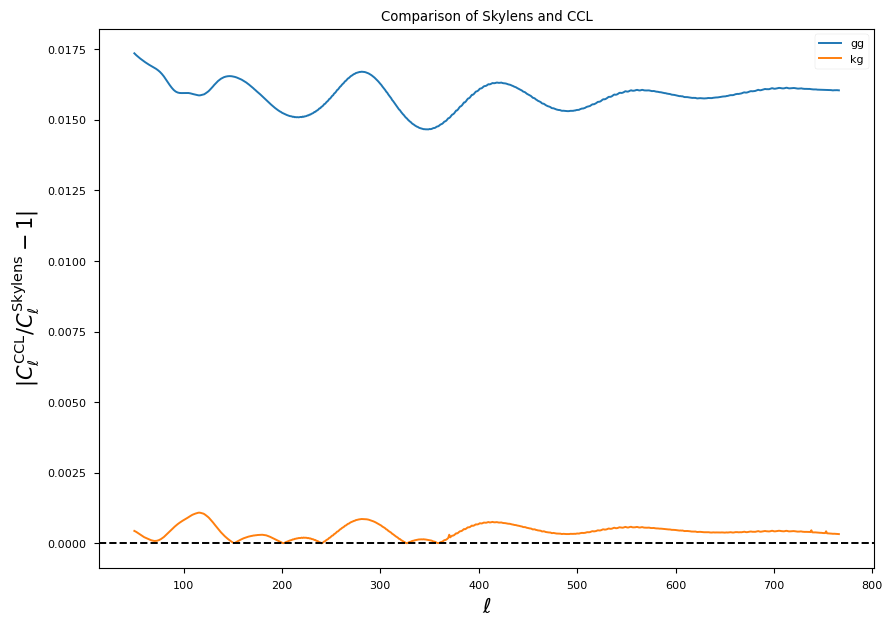

In [24]:
plt.figure(figsize = (10,7))
plt.title("Comparison of Skylens and CCL")

for key in ['gg', 'kg']:
    plt.plot(l[50:], np.abs(ccl_ang_PS[key]/c_ell_dict[key] - 1)[50:], label = key)

plt.axhline(0, c = 'k', ls = '--')
plt.ylabel(r"$\left| C^{\rm CCL}_{\ell}/C^{\rm Skylens}_{\ell} - 1 \right|$", fontsize = 15)
plt.xlabel(r"$\ell$", fontsize = 15)
plt.legend(loc = 'best')
plt.show()

**Observation:** There is a $\sim 1.5\%$ bias between Skylens and CCL in auto. This will have to investigated later on.
Possible sources of issues may include:
- Difference in halofit model
- Difference in interpolation scheme; Skylens uses linear interpolation while CCL uses splines

### Further test by comparing $P(k)$

In [25]:
z = 1.1
skylens_pk, skylens_k = kappa0.Ang_PS.PS.camb_pk(z = np.array([z]))

In [26]:
k = skylens_k*cosmo_params['h']
a = 1/(1 + z)
pk_nl = ccl.nonlin_matter_power(cosmo_ccl, k, a)

11:48:56 DEBUG:vmin 0.00012058944903640958 vmax 11.388746618996008
11:48:56 DEBUG:ticklocs array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03])
11:48:56 DEBUG:vmin 0.00012058944903640958 vmax 11.388746618996008
11:48:56 DEBUG:ticklocs array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03])
11:48:56 DEBUG:vmin 0.00012058944903640958 vmax 11.388746618996008
11:48:56 DEBUG:ticklocs array([2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05, 8.e-05, 9.e-05,
       2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8

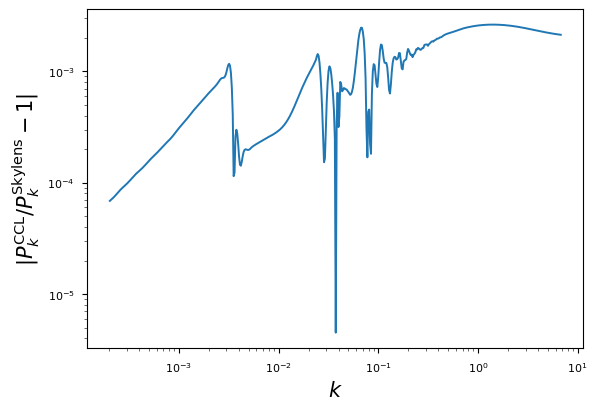

In [29]:
plt.loglog(k, np.abs(((skylens_pk[0]*cosmo_params['h']**(-3))/pk_nl) - 1))
plt.axhline(0, c = 'k', ls = '--')
plt.ylabel(r"$\left| P^{\rm CCL}_{k}/P^{\rm Skylens}_{k} - 1 \right|$", fontsize = 15)
plt.xlabel(r"$k$", fontsize = 15)
plt.show()

# Pseudo-$C_{\ell}$ Comparison

In [34]:
import healpy as hp

First, we generate correlated maps using `healpy`

In [57]:
map_gg, map_kk = hp.synfast((c_ell_dict['gg'], c_ell_dict['kg'], c_ell_dict['kk']), nside = 1024, pol = False)

/global/homes/t/tanveerk/.conda/envs/myenv_perlmutter/lib/python3.7/site-packages/healpy/sphtfunc.py:438: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,
/global/homes/t/tanveerk/.conda/envs/myenv_perlmutter/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/global/homes/t/tanveerk/.conda/envs/myenv_perlmutter/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


Apply relevant masks

In [58]:
window_gg = np.load(gal_window_dict[0])
mask_gg = np.load(gal_maskfile)
window_cmb = np.load(cmb_window_map_file[0])

In [59]:
map_gg[mask_gg] = map_gg[mask_gg] * window_gg[mask_gg] #ELGs
map_gg[~mask_gg] = hp.UNSEEN
map_kk = map_kk * window_cmb #CMB lensing 

Calculate observer power spectra

In [63]:
obs_pcl = {}
obs_pcl['gg'] = hp.anafast(map_gg, pol = False)
obs_pcl['kk'] = hp.anafast(map_kk, pol = False)
obs_pcl['kg'] = hp.anafast(map_gg, map_kk, pol = False)

Mean for gg is: 0.0033783943803674535
Mean for kk is: 4.5497231176646736e-05
Mean for kg is: 0.0010502025059172648


Text(0.5, 0, '$\\ell$')

12:11:42 DEBUG:vmin 0.7174449145176851 vmax 1067.6777889142288
12:11:42 DEBUG:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
12:11:42 DEBUG:vmin 0.7174449145176851 vmax 1067.6777889142288
12:11:42 DEBUG:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
12:11:42 DEBUG:vmin 0.7174449145176851 vmax 1067.6777889142288
12:11:42 DEBUG:ticklocs array([2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05])
12:11:42 DEBUG:vmin 0.7174

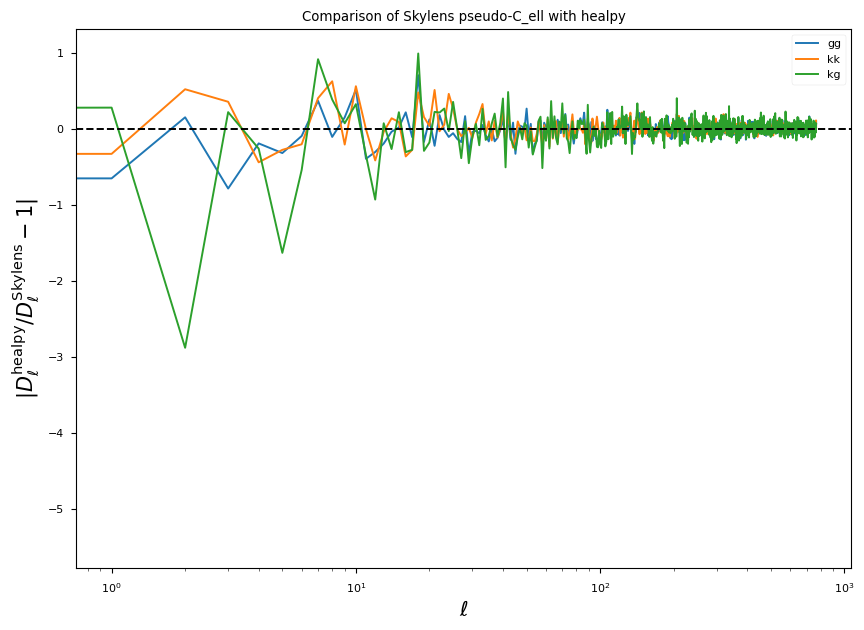

In [72]:
plt.figure(figsize = (10,7))

plt.title("Comparison of Skylens pseudo-C_ell with healpy")

for tracer in obs_pcl:
    plt.semilogx(np.arange(len(c_ell_dict[tracer])), 
               (obs_pcl[tracer][:len(c_ell_dict[tracer])]/c_ell_dict['p'+tracer] - 1), label = tracer)
    print(f"Mean for {tracer} is: {((obs_pcl[tracer][:len(c_ell_dict[tracer])]/c_ell_dict['p'+tracer])[50:] - 1).mean()}")
plt.legend(loc = 'best')
plt.axhline(0, c = 'k', ls = '--')
plt.ylabel(r"$\left| D^{\rm healpy}_{\ell}/D^{\rm Skylens}_{\ell} - 1 \right|$", fontsize = 15)
plt.xlabel(r"$\ell$", fontsize = 15)

**Observation:** Skylens pseudo-$C_{\ell}$ calculation has subpercent-level precision.